In [7]:
%pip install transformers datasets torch pandas matplotlib seaborn

import datasets
from datasets import load_dataset
from transformers import pipeline
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

device = 0 if torch.cuda.is_available() else -1
print(f"사용 가능한 디바이스: {'GPU' if device == 0 else 'CPU'}")

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.
사용 가능한 디바이스: CPU


In [8]:
print("CNN/DailyMail 데이터셋을 로드하는 중...")

full_dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")

num_samples_to_use = 40
cnn_subset = full_dataset.select(range(num_samples_to_use))

print("로드된 데이터셋 정보:")
print(cnn_subset)
print(f"\n사용할 샘플 수: {len(cnn_subset)}")

print("\n첫 번째 데이터 예시:")
print("--- 원본 기사 (Article) ---")
print(cnn_subset[0]['article'][:500] + "...")
print("\n--- 참고 요약문 (Highlights) ---")
print(cnn_subset[0]['highlights'])

print("\n데이터셋 컬럼:", cnn_subset.column_names)


CNN/DailyMail 데이터셋을 로드하는 중...
로드된 데이터셋 정보:
Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 40
})

사용할 샘플 수: 40

첫 번째 데이터 예시:
--- 원본 기사 (Article) ---
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, includin...

--- 참고 요약문 (Highlights) ---
Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .

데이터셋 컬럼: ['article', 'highlights', 'id']


In [9]:
print("요약 모델을 로드하는 중...")

# BART 모델 사용 
summarizer = pipeline(
    task="summarization",
    model="facebook/bart-large-cnn",
    device=device
)

print("요약 파이프라인 로드 완료.")
print(f"사용 모델: facebook/bart-large-cnn")
print(f"디바이스: {'GPU' if device == 0 else 'CPU'}")

# 모델 테스트
test_text = """
The quick brown fox jumps over the lazy dog. This is a test sentence to check if the summarization model is working correctly. 
The model should be able to extract the main points from longer texts and create concise summaries.
"""

test_summary = summarizer(test_text, max_length=50, min_length=20)
print("\n모델 테스트 결과:")
print(f"입력: {test_text.strip()}")
print(f"요약: {test_summary[0]['summary_text']}")


요약 모델을 로드하는 중...


Device set to use cpu


요약 파이프라인 로드 완료.
사용 모델: facebook/bart-large-cnn
디바이스: CPU

모델 테스트 결과:
입력: The quick brown fox jumps over the lazy dog. This is a test sentence to check if the summarization model is working correctly. 
The model should be able to extract the main points from longer texts and create concise summaries.
요약: The quick brown fox jumps over the lazy dog. This is a test sentence to check if the summarization model is working correctly.


In [10]:
def summarize_article(example):
    try:
        article_text = example['article']
        if len(article_text) > 2000: 
            article_text = article_text[:2000]
        
        summary_result = summarizer(
            article_text,
            max_length=150,
            min_length=30,
            do_sample=False  
        )
        
        # 결과에서 요약 텍스트 추출
        example['generated_summary'] = summary_result[0]['summary_text']
        
    except Exception as e:
        print(f"요약 중 오류 발생: {e}")
        example['generated_summary'] = "요약 실패"
    
    return example

print("요약 작업을 시작합니다... (데이터 양에 따라 시간이 소요될 수 있습니다)")
print(f"처리할 샘플 수: {len(cnn_subset)}")

summarized_dataset = cnn_subset.map(
    summarize_article,
    batched=False,  
    desc="기사 요약 중..."
)

print("요약 작업 완료.")

print("\n요약이 추가된 데이터셋 정보:")
print(summarized_dataset)

# 첫 번째 데이터의 결과 확인
print("\n첫 번째 데이터의 원문과 생성된 요약:")
print("--- 원본 기사 (Article) ---")
print(summarized_dataset[0]['article'][:300] + "...")
print("\n--- 생성된 요약 (Generated Summary) ---")
print(summarized_dataset[0]['generated_summary'])
print("\n--- 참고 요약문 (Highlights) ---")
print(summarized_dataset[0]['highlights'])


요약 작업을 시작합니다... (데이터 양에 따라 시간이 소요될 수 있습니다)
처리할 샘플 수: 40


기사 요약 중...: 100%|██████████| 40/40 [10:41<00:00, 16.03s/ examples]

요약 작업 완료.

요약이 추가된 데이터셋 정보:
Dataset({
    features: ['article', 'highlights', 'id', 'generated_summary'],
    num_rows: 40
})

첫 번째 데이터의 원문과 생성된 요약:
--- 원본 기사 (Article) ---
(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the cou...

--- 생성된 요약 (Generated Summary) ---
The Palestinian Authority officially becomes the 123rd member of the International Criminal Court. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based.

--- 참고 요약문 (Highlights) ---
Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .


In [11]:
print("요약 결과 분석을 시작합니다...")

df_results = pd.DataFrame(summarized_dataset)

# 요약문 길이 계산 (단어 수 기준)
df_results['article_word_count'] = df_results['article'].apply(lambda x: len(x.split()))
df_results['generated_summary_word_count'] = df_results['generated_summary'].apply(lambda x: len(x.split()) if x != "요약 실패" else 0)
df_results['highlights_word_count'] = df_results['highlights'].apply(lambda x: len(x.split()))

# 요약 비율 계산
df_results['compression_ratio'] = df_results['generated_summary_word_count'] / df_results['article_word_count']

# 기본 통계 출력
print("\n=== 요약 결과 통계 ===")
print(f"총 처리된 샘플 수: {len(df_results)}")
print(f"요약 실패한 샘플 수: {len(df_results[df_results['generated_summary'] == '요약 실패'])}")
print(f"성공적으로 요약된 샘플 수: {len(df_results[df_results['generated_summary'] != '요약 실패'])}")

# 길이 통계
successful_summaries = df_results[df_results['generated_summary'] != '요약 실패']
if len(successful_summaries) > 0:
    print("\n=== 길이 통계 ===")
    print(f"원문 평균 길이: {successful_summaries['article_word_count'].mean():.1f} 단어")
    print(f"생성된 요약 평균 길이: {successful_summaries['generated_summary_word_count'].mean():.1f} 단어")
    print(f"참고 요약 평균 길이: {successful_summaries['highlights_word_count'].mean():.1f} 단어")
    print(f"평균 압축 비율: {successful_summaries['compression_ratio'].mean():.3f}")

# 상위 5개 샘플 결과 출력
print("\n=== 상위 5개 샘플 결과 ===")
for i in range(min(5, len(successful_summaries))):
    print(f"\n--- 샘플 {i+1} ---")
    print(f"원문 길이: {successful_summaries.iloc[i]['article_word_count']} 단어")
    print(f"생성된 요약: {successful_summaries.iloc[i]['generated_summary']}")
    print(f"참고 요약: {successful_summaries.iloc[i]['highlights']}")
    print(f"압축 비율: {successful_summaries.iloc[i]['compression_ratio']:.3f}")


요약 결과 분석을 시작합니다...

=== 요약 결과 통계 ===
총 처리된 샘플 수: 40
요약 실패한 샘플 수: 0
성공적으로 요약된 샘플 수: 40

=== 길이 통계 ===
원문 평균 길이: 623.8 단어
생성된 요약 평균 길이: 37.1 단어
참고 요약 평균 길이: 36.1 단어
평균 압축 비율: 0.083

=== 상위 5개 샘플 결과 ===

--- 샘플 1 ---
원문 길이: 567 단어
생성된 요약: The Palestinian Authority officially becomes the 123rd member of the International Criminal Court. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based.
참고 요약: Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .
Israel and the United States opposed the move, which could open the door to war crimes investigations against Israelis .
압축 비율: 0.056

--- 샘플 2 ---
원문 길이: 411 단어
생성된 요약: Theia was hit by a car, apparently whacked on the head with a hammer and buried in a field. Four days after her apparent death, the dog managed to stagger to a nearby farm. She was found by a worker who took her to a vet for help. She suffered a dislocated jaw, leg i

/var/folders/xt/6hqj9_8d223c_wq515gdl8m80000gn/T/ipykernel_47444/3075486269.py:41: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xt/6hqj9_8d223c_wq515gdl8m80000gn/T/ipykernel_47444/3075486269.py:41: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xt/6hqj9_8d223c_wq515gdl8m80000gn/T/ipykernel_47444/3075486269.py:41: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xt/6hqj9_8d223c_wq515gdl8m80000gn/T/ipykernel_47444/3075486269.py:41: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xt/6hqj9_8d223c_wq515gdl8m80000gn/T/ipykernel_47444/3075486269.py:41: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/xt/6hqj9_8d223c_wq515gdl8m80000gn/T/ipykernel

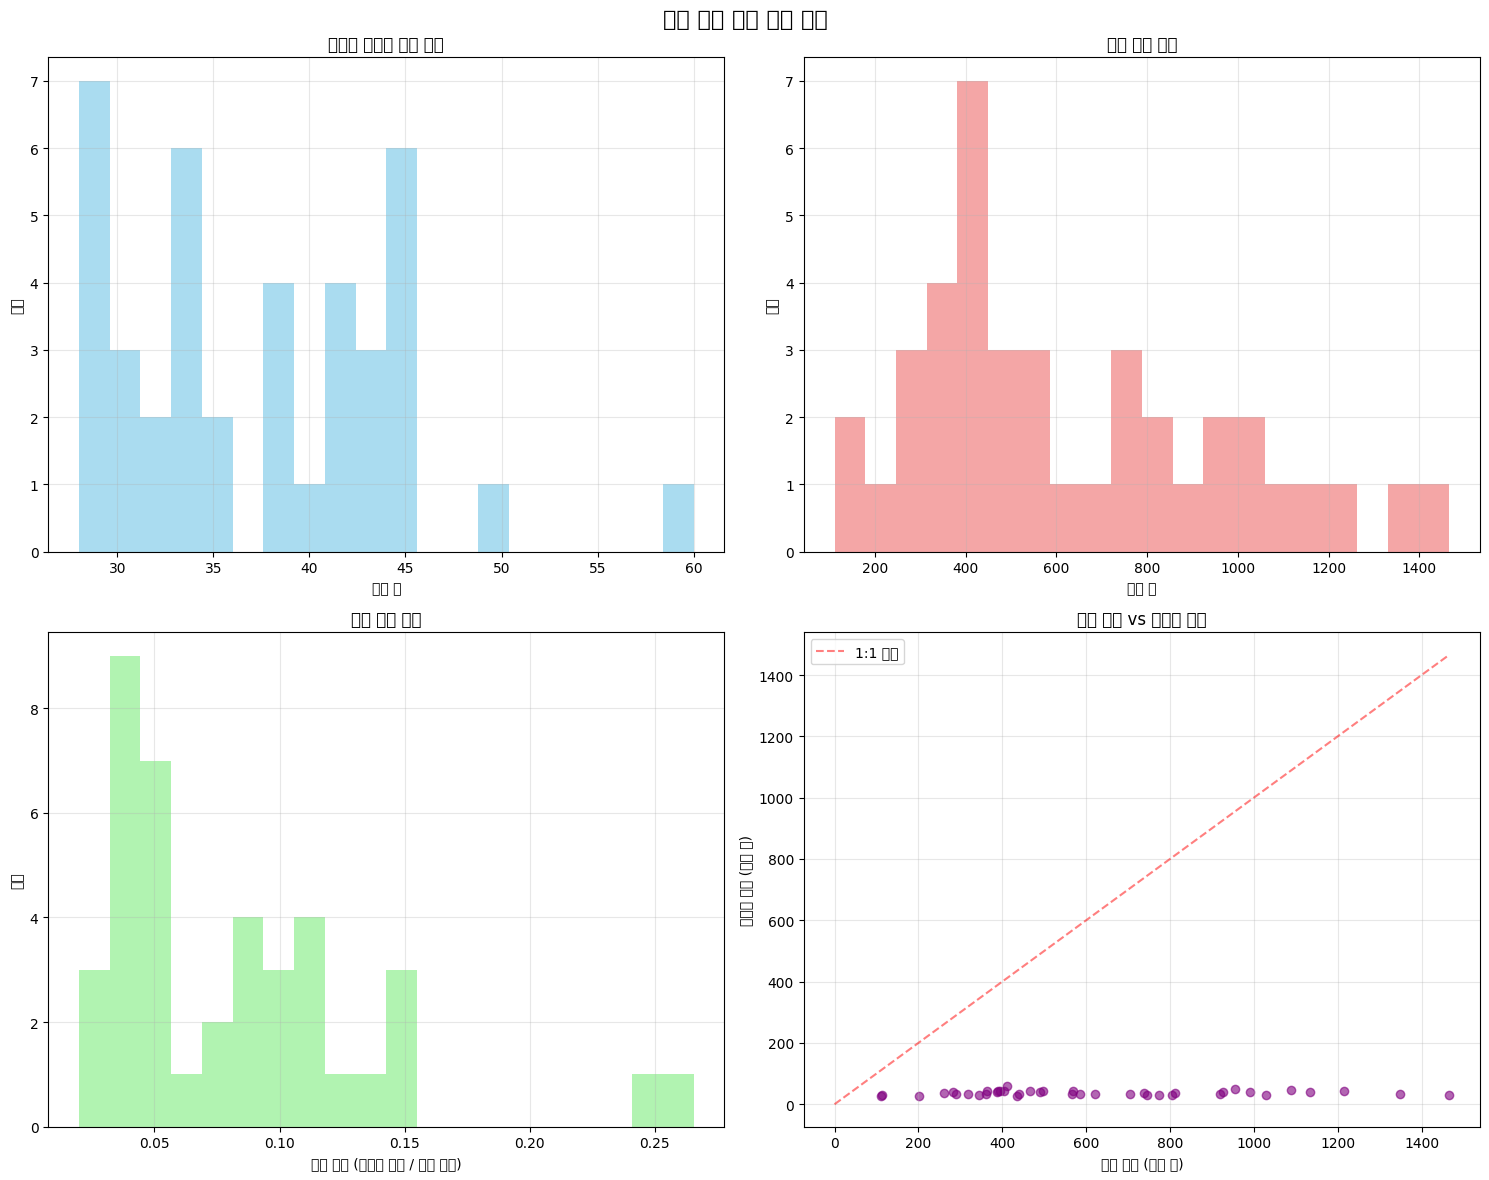


=== 압축 비율별 통계 ===
count    40.000000
mean      0.082851
std       0.054876
min       0.019782
25%       0.040849
50%       0.069684
75%       0.108697
max       0.265487
Name: compression_ratio, dtype: float64

압축 비율 구간별 분포:
0-10%: 27개 (67.5%)
10-20%: 11개 (27.5%)
20-30%: 2개 (5.0%)
30-50%: 0개 (0.0%)
50%+: 0개 (0.0%)


In [12]:
if len(successful_summaries) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('뉴스 기사 요약 결과 분석', fontsize=16, fontweight='bold')
    
    # 1. 요약문 길이 분포
    axes[0, 0].hist(successful_summaries['generated_summary_word_count'], bins=20, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('생성된 요약문 길이 분포')
    axes[0, 0].set_xlabel('단어 수')
    axes[0, 0].set_ylabel('빈도')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. 원문 길이 분포
    axes[0, 1].hist(successful_summaries['article_word_count'], bins=20, alpha=0.7, color='lightcoral')
    axes[0, 1].set_title('원문 길이 분포')
    axes[0, 1].set_xlabel('단어 수')
    axes[0, 1].set_ylabel('빈도')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 압축 비율 분포
    axes[1, 0].hist(successful_summaries['compression_ratio'], bins=20, alpha=0.7, color='lightgreen')
    axes[1, 0].set_title('압축 비율 분포')
    axes[1, 0].set_xlabel('압축 비율 (요약문 길이 / 원문 길이)')
    axes[1, 0].set_ylabel('빈도')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 원문 길이 vs 요약문 길이 산점도
    axes[1, 1].scatter(successful_summaries['article_word_count'], 
                      successful_summaries['generated_summary_word_count'], 
                      alpha=0.6, color='purple')
    axes[1, 1].set_title('원문 길이 vs 요약문 길이')
    axes[1, 1].set_xlabel('원문 길이 (단어 수)')
    axes[1, 1].set_ylabel('요약문 길이 (단어 수)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # 대각선 추가 (1:1 비율)
    max_length = max(successful_summaries['article_word_count'].max(), 
                    successful_summaries['generated_summary_word_count'].max())
    axes[1, 1].plot([0, max_length], [0, max_length], 'r--', alpha=0.5, label='1:1 비율')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n=== 압축 비율별 통계 ===")
    compression_stats = successful_summaries['compression_ratio'].describe()
    print(compression_stats)
    
    compression_ranges = pd.cut(successful_summaries['compression_ratio'], 
                               bins=[0, 0.1, 0.2, 0.3, 0.5, 1.0], 
                               labels=['0-10%', '10-20%', '20-30%', '30-50%', '50%+'])
    range_counts = compression_ranges.value_counts().sort_index()
    
    print("\n압축 비율 구간별 분포:")
    for range_name, count in range_counts.items():
        percentage = (count / len(successful_summaries)) * 100
        print(f"{range_name}: {count}개 ({percentage:.1f}%)")
else:
    print("시각화할 성공적인 요약 결과가 없습니다.")


In [15]:
print("모든 작업이 완료되었습니다.")
print("\n=== 최종 결과 요약 ===")
print(f"처리된 총 샘플 수: {len(summarized_dataset)}")
print(f"성공적으로 요약된 샘플 수: {len(successful_summaries) if len(successful_summaries) > 0 else 0}")
print(f"요약 실패한 샘플 수: {len(df_results[df_results['generated_summary'] == '요약 실패'])}")

if len(successful_summaries) > 0:
    print(f"평균 압축 비율: {successful_summaries['compression_ratio'].mean():.3f}")
    print(f"평균 요약문 길이: {successful_summaries['generated_summary_word_count'].mean():.1f} 단어")

print("\n최종 데이터셋 컬럼:", summarized_dataset.column_names)


모든 작업이 완료되었습니다.

=== 최종 결과 요약 ===
처리된 총 샘플 수: 40
성공적으로 요약된 샘플 수: 40
요약 실패한 샘플 수: 0
평균 압축 비율: 0.083
평균 요약문 길이: 37.1 단어

최종 데이터셋 컬럼: ['article', 'highlights', 'id', 'generated_summary']
